<a href="https://colab.research.google.com/github/guilhermegreis/processamento-de-img-m2/blob/main/Processamento_IMG_M2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

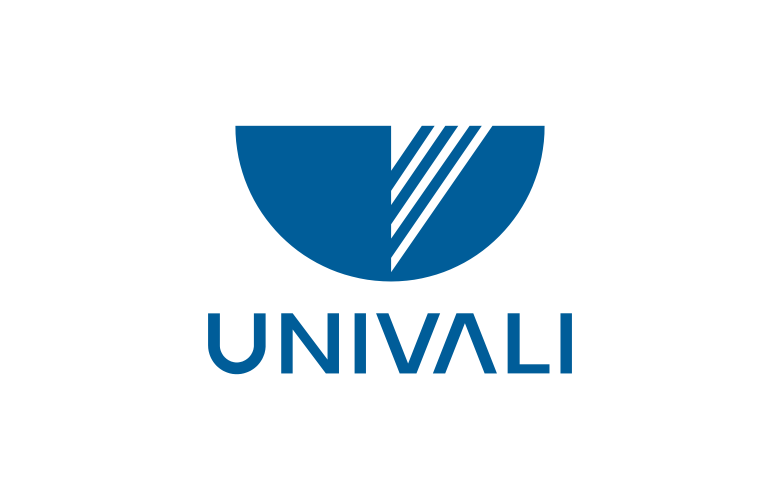
# Trabalho de Processamento de Imagens - Projeto M2: Filtragem na frequência, morfologia e segmentação.
# Universidade do Vale do Itajaí - Univali.
# Professor: Felipe Viel.
# Aluno: Guilherme G. Reis.


#Parte 1 – Segmentação com Watershed e SLIC

##1 - Carregar as imagens (BSD500 ou VOC2012) e adicionar ruído gaussiano.


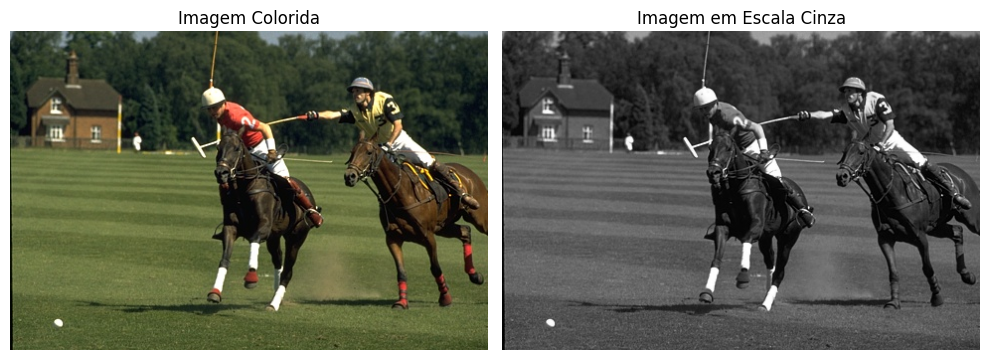

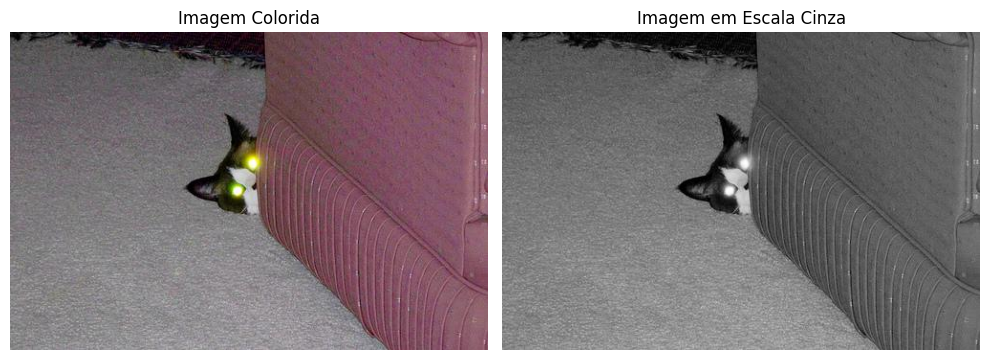

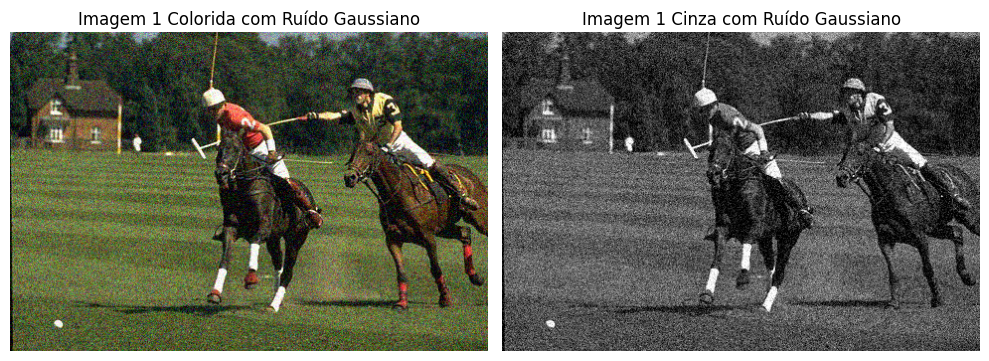

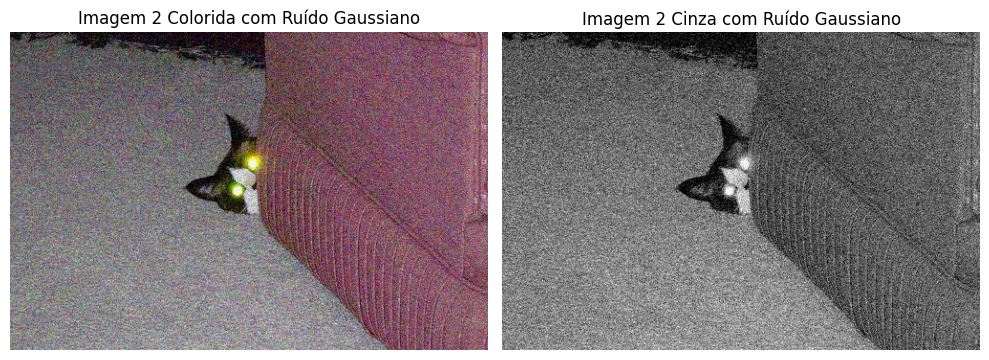

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import cv2

path_img1 = './cavalos.jpg'
path_img2 = './gato.jpg'


# Função para converter BGR para escala de cinza
def rgb_to_gray(rgb_img):
    return (0.2989 * rgb_img[:, :, 0] +
            0.5870 * rgb_img[:, :, 1] +
            0.1140 * rgb_img[:, :, 2]).astype(np.uint8)

def bgr_to_rgb(img):
    return img[:, :, ::-1]

# Função para carregar a imagem e converter
def load_img(path):
    img = cv2.imread(path)
    img_float = img.astype(np.float32)
    gray = rgb_to_gray(img)


  # Mostrar imagens
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(bgr_to_rgb(img).astype(np.uint8))
    plt.title('Imagem Colorida')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(gray, cmap='gray')
    plt.title('Imagem em Escala Cinza')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    return img, gray

color_img, gray_img = load_img(path_img1)
color_img2, gray_img2 = load_img(path_img2)

# Função pra colocar ruído gaussiano
def gaussian_noise(image, mean=0, sigma=25):
    noisy = image / 255.0
    gauss = np.random.normal(mean, sigma/255.0, image.shape)
    noisy = noisy + gauss
    noisy = np.clip(noisy, 0, 1)
    noisy = (noisy * 255).astype(np.uint8)
    return noisy

# Ruído gaussiano nas imagens coloridas e em escala de cinza
noisy_color = gaussian_noise(color_img)
noisy_gray = gaussian_noise(gray_img)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(bgr_to_rgb(noisy_color).astype(np.uint8))
plt.title('Imagem 1 Colorida com Ruído Gaussiano')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(noisy_gray, cmap='gray')
plt.title('Imagem 1 Cinza com Ruído Gaussiano')
plt.axis('off')
plt.tight_layout()
plt.show()

noisy_color2 = gaussian_noise(color_img2)
noisy_gray2 = gaussian_noise(gray_img2)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(bgr_to_rgb(noisy_color2).astype(np.uint8))
plt.title('Imagem 2 Colorida com Ruído Gaussiano')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(noisy_gray2, cmap='gray')
plt.title('Imagem 2 Cinza com Ruído Gaussiano')
plt.axis('off')
plt.tight_layout()
plt.show()


#SPECKLE TESTE
# def speckle_noise(img, mean=0, std_dev=0.1):
#     noise = np.random.normal(mean, std_dev, img.shape)
#     noisy_img = img + img * noise  # multiplicativo
#     noisy_img = np.clip(noisy_img, 0, 255)
#     return noisy_img.astype(np.uint8 if img.dtype == np.uint8 else img.dtype)

# noisy_speckle_color = speckle_noise(color_img)
# noisy_speckle_gray = speckle_noise(gray_img)

# plt.subplot(1, 2, 1)
# plt.imshow(bgr_to_rgb(noisy_speckle_color).astype(np.uint8))
# plt.title("Colorida com Speckle")
# plt.axis('off')

# plt.subplot(1, 2, 2)
# plt.imshow(noisy_speckle_gray, cmap='gray')
# plt.title("Cinza com Speckle")
# plt.axis('off')

# plt.show()

##2 - Filtragem no domínio da frequência - Ex: Gaussiano ou Butterworth - Mostrar espectros antes e depois, aplicar a transformada inversa para retornar ao domínio espacial.

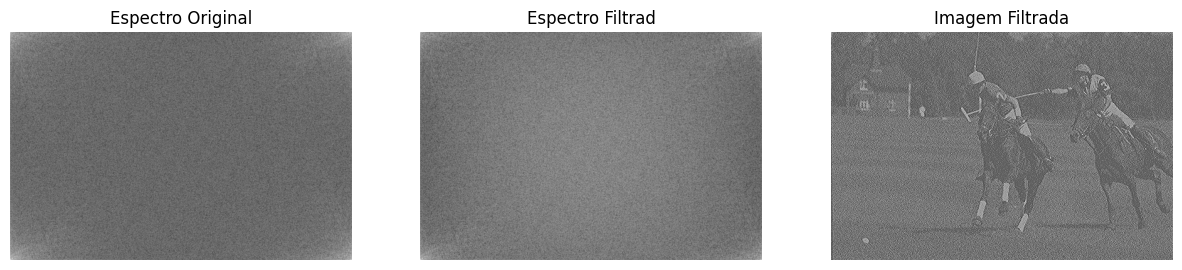

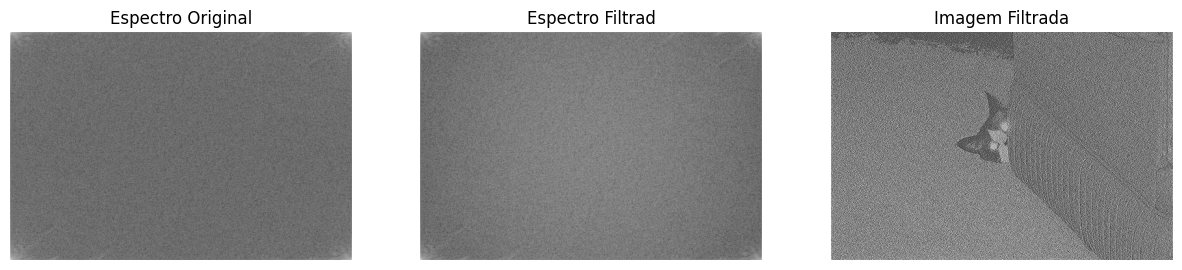

In [25]:
# Filtro Ideal
def ideal_filter(shape, D0, highpass=False):
     P, Q = shape
     H = np.zeros((P, Q))
     for u in range(P):
         for v in range(Q):
             D = np.sqrt((u - P//2)**2 + (v - Q//2)**2)
             if (D > D0 and highpass) or (D <= D0 and not highpass):
                 H[u, v] = 1
     return H

# Filtro Gaussiano
def gaussian_filter(shape, D0, highpass=False):
    P, Q = shape
    u = np.arange(P) - P // 2
    v = np.arange(Q) - Q // 2
    V, U = np.meshgrid(v, u)
    D = np.sqrt(U**2 + V**2)
    H = np.exp(-(D**2) / (2 * D0**2))
    if highpass:
        H = 1 - H
    return H

# Filtro Butterworth
def butterworth_filter(shape, D0, n=2, highpass=False, squared=False):
    P, Q = shape
    u = np.arange(P) - P // 2
    v = np.arange(Q) - Q // 2
    V, U = np.meshgrid(v, u)
    D = np.sqrt(U**2 + V**2)

    H = 1 / (1 + (D / D0)**(2 * n))
    if squared:
        H = H**2
    if highpass:
        H = 1 - H
    return H

def frequency_filter(gray_img, D0, order=2, highpass=False, squared=False):
    M, N = gray_img.shape
    P, Q = 2 * M, 2 * N  # padding

    padded = np.zeros((P, Q), dtype=np.float32)
    padded[:M, :N] = gray_img

    center_factor = np.fromfunction(lambda x, y: (-1) ** (x + y), (P, Q))
    centered = padded * center_factor

    F = np.fft.fft2(centered)
    F_shifted = np.fft.fftshift(F)


    # Pra usar filtro Butterworth
    #H = butterworth_filter((P, Q), D0, n=order, highpass=highpass, squared=squared)
    # Pra usar o filtro Gaussiano
    H = gaussian_filter((P, Q), D0, highpass=highpass)
    # Pra usar o Ideal
    #H = ideal_filter((P, Q), D0, highpass=highpass)

    G_shifted = F_shifted * H

    G = np.fft.ifftshift(G_shifted)
    g = np.fft.ifft2(G)
    g = np.real(g)

    g = g * center_factor
    g_final = g[:M, :N]

    #g_final_norm = 255 * (g_final - g_final.min()) / (g_final.max() - g_final.min() + 1e-10)
    g_final_norm = g_final

    spectrum_original = np.log1p(np.abs(F_shifted))
    spectrum_filtered = np.log1p(np.abs(G_shifted))

    return g_final_norm, spectrum_original, spectrum_filtered

def normalize_img(img):
    img_min = img.min()
    img_max = img.max()
    return (img - img_min) / (img_max - img_min + 1e-10)

params_img1 = {
    "D0": int(min(gray_img.shape) * 0.9),
    "order": 3
}
params_img2 = {
    "D0": int(min(gray_img.shape) * 1),
    "order": 3
}

def show_uniform_results(img_gray, D0, order):
    filtered_img, spectrum_original, spectrum_filtered = frequency_filter(img_gray, D0, order=order, highpass=False)

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title("Espectro Original")
    plt.imshow(spectrum_original, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("Espectro Filtrad")
    plt.imshow(spectrum_filtered, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title("Imagem Filtrada")
    plt.imshow(filtered_img, cmap='gray')
    plt.axis('off')

    plt.show()

# Usar nas imagens com ruído gaussiano
show_uniform_results(noisy_gray, **params_img1)
show_uniform_results(noisy_gray2, **params_img2)

##3 - Avaliar a qualidade da filtragem usando métricas - PSNR ou SSIM (opcional)


In [27]:
def psnr_float(original, compared):
    mse = np.mean((original - compared) ** 2)
    if mse == 0:
        return float('inf')
    return 10 * np.log10(1.0 / mse)

def standard_to_psnr(img):
    img_norm = 255 * (img - img.min()) / (img.max() - img.min() + 1e-10)
    return img_norm.astype(np.uint8)

def psnr(original, compared, max_pixel=255.0):
    original = original.astype(np.float32)
    compared = compared.astype(np.float32)
    mse = np.mean((original - compared) ** 2)
    if mse == 0:
        return float('inf')
    return 10 * np.log10((max_pixel ** 2) / mse)

gray_img_norm = normalize_img(gray_img.astype(np.float32))
noisy_gray_norm = normalize_img(noisy_gray.astype(np.float32))

filtered = frequency_filter(noisy_gray_norm, **params_img1)[0]
filtered_norm = normalize_img(filtered.astype(np.float32))

psnr1 = psnr_float(gray_img_norm, filtered_norm)

gray_img2_norm = normalize_img(gray_img2.astype(np.float32))
noisy_gray2_norm = normalize_img(noisy_gray2.astype(np.float32))

filtered2 = frequency_filter(noisy_gray2_norm, **params_img2)[0]
filtered2_norm = normalize_img(filtered2.astype(np.float32))

psnr2 = psnr_float(gray_img2_norm, filtered2_norm)

print(f"Imagem 1 - PSNR: {psnr1:.2f} dB")
print(f"Imagem 2 - PSNR: {psnr2:.2f} dB")


Imagem 1 - PSNR: 13.50 dB
Imagem 2 - PSNR: 16.21 dB


##4 Segmentação com Watershed e SLIC

Número de marcadores: 121
Número de marcadores: 71


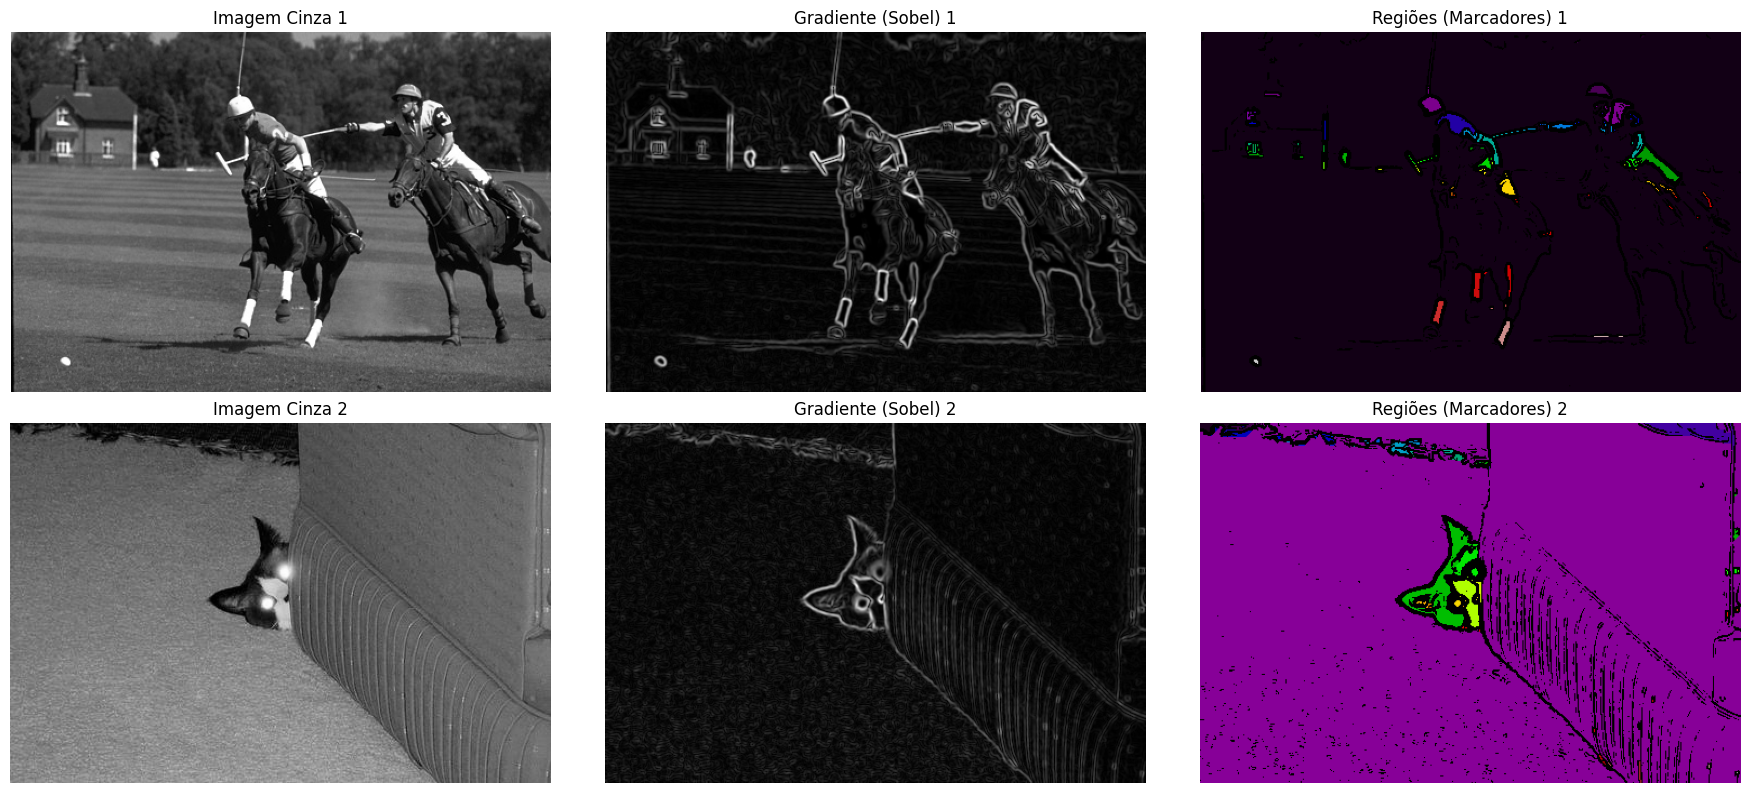

Iteração 1/15
Iteração 2/15
Iteração 3/15
Iteração 4/15
Iteração 5/15
Iteração 6/15
Iteração 7/15
Iteração 8/15
Iteração 9/15
Iteração 10/15
Iteração 11/15
Iteração 12/15
Iteração 13/15
Iteração 14/15
Iteração 15/15
Iteração 1/15
Iteração 2/15
Iteração 3/15
Iteração 4/15
Iteração 5/15
Iteração 6/15
Iteração 7/15
Iteração 8/15
Iteração 9/15
Iteração 10/15
Iteração 11/15
Iteração 12/15
Iteração 13/15
Iteração 14/15
Iteração 15/15


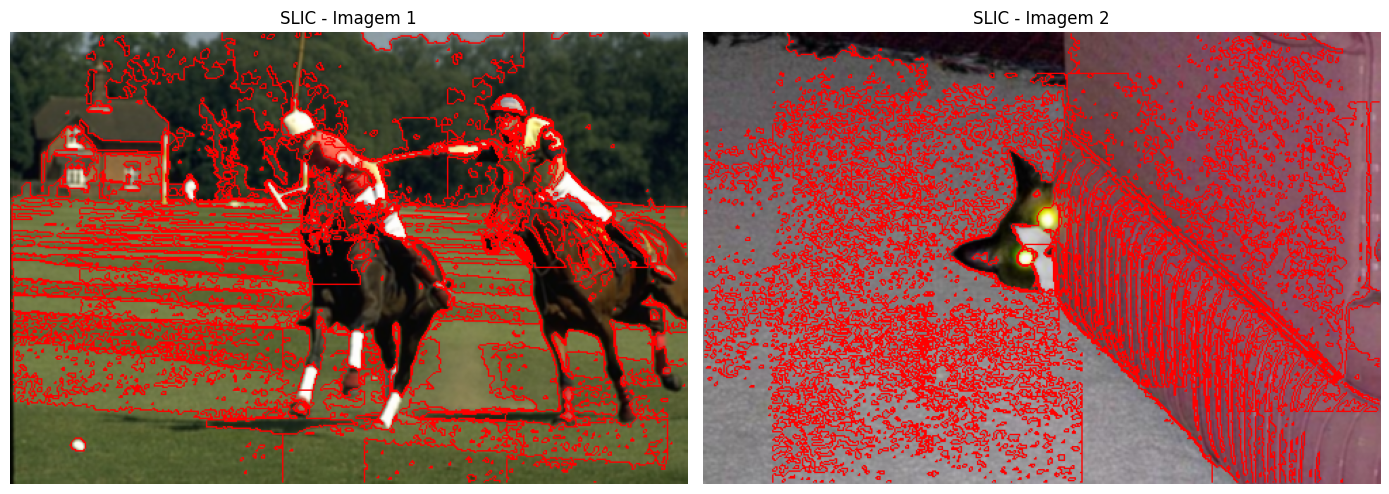

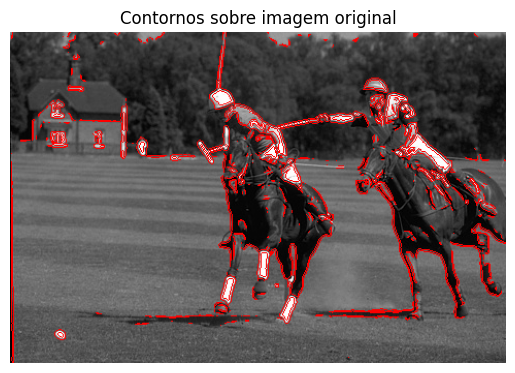

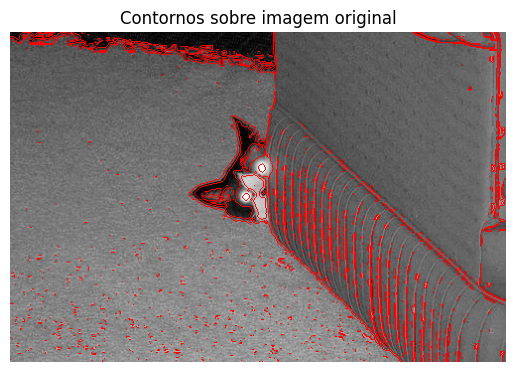

In [30]:
from scipy.ndimage import label, generate_binary_structure
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from skimage.segmentation import find_boundaries

def gaussian_kernel(size, sigma=1):
    k = size // 2
    x = np.arange(-k, k+1)
    y = np.arange(-k, k+1)
    x, y = np.meshgrid(x, y)
    kernel = np.exp(-(x**2 + y**2) / (2*sigma**2))
    kernel /= kernel.sum()
    return kernel

def convolve2d(image, kernel):
    k = kernel.shape[0] // 2
    padded = np.pad(image, k, mode='reflect')
    output = np.zeros_like(image, dtype=np.float64)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            region = padded[i:i+kernel.shape[0], j:j+kernel.shape[1]]
            output[i,j] = np.sum(region * kernel)
    return output

def apply_gaussian_filter(img, size=3, sigma=1):
    kernel = gaussian_kernel(size, sigma)
    if img.ndim == 2:  # imagem em escala de cinza
        return convolve2d(img, kernel)
    else:  # imagem colorida
        canais = []
        for i in range(3):
            canais.append(convolve2d(img[:, :, i], kernel))
        return np.stack(canais, axis=-1).astype(np.uint8)

color_img = np.array(Image.open(path_img1).convert('RGB'))
color_img2 = np.array(Image.open(path_img2).convert('RGB'))

gray_img = rgb_to_gray(color_img)
gray_img2 = rgb_to_gray(color_img2)

# Suavização opcional
color_img = apply_gaussian_filter(color_img, size=3, sigma=1)
color_img2 = apply_gaussian_filter(color_img2, size=3, sigma=1)

def sobel_gradient(gray):
    sobel_x = np.array([[-1, 0, 1],
                        [-2, 0, 2],
                        [-1, 0, 1]], dtype=np.float64)
    sobel_y = np.array([[1, 2, 1],
                        [0, 0, 0],
                        [-1, -2, -1]], dtype=np.float64)

    grad_x = convolve2d(gray, sobel_x)
    grad_y = convolve2d(gray, sobel_y)
    gradient = np.sqrt(grad_x**2 + grad_y**2)
    gradient = (gradient / gradient.max() * 255).astype(np.uint8)
    return gradient

def otsu_threshold(image):
    # Calcula histograma
    hist, bins = np.histogram(image.flatten(), bins=256, range=(0, 256))
    total = image.size
    sum_all = np.dot(np.arange(256), hist)

    sumB, wB, max_var, threshold = 0, 0, 0, 0

    for t in range(256):
        wB += hist[t]
        if wB == 0:
            continue
        wF = total - wB
        if wF == 0:
            break
        sumB += t * hist[t]
        mB = sumB / wB
        mF = (sum_all - sumB) / wF
        var_between = wB * wF * (mB - mF)**2

        if var_between > max_var:
            max_var = var_between
            threshold = t

    binary = np.zeros_like(image, dtype=np.uint8)
    binary[image > threshold] = 255
    return binary

def connected_components_labeling(binary):
    h, w = binary.shape
    labels = np.zeros((h, w), dtype=np.int32)
    label = 1
    equivalences = {}

    def neighbors(y, x):
        nbrs = []
        if y > 0:
            nbrs.append(labels[y-1, x])       # cima
            if x > 0:
                nbrs.append(labels[y-1, x-1]) # cima-esq
            if x < w-1:
                nbrs.append(labels[y-1, x+1]) # cima-dir
        if x > 0:
            nbrs.append(labels[y, x-1])       # esquerda
        return [n for n in nbrs if n > 0]

    for y in range(h):
        for x in range(w):
            if binary[y, x] == 0:
                continue
            nbrs = neighbors(y, x)
            if not nbrs:
                labels[y, x] = label
                equivalences[label] = {label}
                label += 1
            else:
                min_label = min(nbrs)
                labels[y, x] = min_label
                for l in nbrs:
                    equivalences[min_label] = equivalences[min_label].union(equivalences[l])
                    equivalences[l] = equivalences[min_label]

    # Segunda passada para resolver equivalências
    label_map = {}
    new_label = 1
    for y in range(h):
        for x in range(w):
            if labels[y, x] > 0:
                root_label = min(equivalences[labels[y, x]])
                if root_label not in label_map:
                    label_map[root_label] = new_label
                    new_label += 1
                labels[y, x] = label_map[root_label]

    return labels, new_label - 1

def overlay_contours(gray_img, labels):
    boundaries = find_boundaries(labels, mode='outer')
    overlay = gray_img.copy()
    overlay = np.stack([overlay]*3, axis=-1)  # converter para RGB

    overlay[boundaries] = [255, 0, 0]  # destacar contornos em vermelho

    plt.imshow(overlay)
    plt.title("Contornos sobre imagem original")
    plt.axis('off')
    plt.show()

def watershed(gray):
    # Reduzir ruído
    blur = apply_gaussian_filter(gray, size=3, sigma=1)

    # Gradiente Sobel
    gradient = sobel_gradient(blur)

    # Threshold Otsu
    markers = otsu_threshold(gradient)
    markers = 255 - markers

    # Componentes
    labeled, n_labels = connected_components_labeling(markers)

    print(f"Número de marcadores: {n_labels}")
    return labeled, gradient

def slic(img_rgb, n_segments=15, max_iter=15):
    h, w, c = img_rgb.shape
    S = int(np.sqrt(h * w / n_segments))  # Espaçamento entre centros

    centers = []
    for y in range(S//2, h, S):
        for x in range(S//2, w, S):
            centers.append([y, x, *img_rgb[y, x]])

    centers = np.array(centers, dtype=np.float64)
    labels = -1 * np.ones((h, w), dtype=int)
    distances = np.full((h, w), np.inf)

    for it in range(max_iter):
        print(f"Iteração {it + 1}/{max_iter}")
        for idx, center in enumerate(centers):
            cy, cx, r, g, b = center
            cy, cx = int(cy), int(cx)
            y0, y1 = max(cy - S, 0), min(cy + S, h)
            x0, x1 = max(cx - S, 0), min(cx + S, w)

            for y in range(y0, y1):
                for x in range(x0, x1):
                    R, G, B = img_rgb[y, x]
                    dc = np.sqrt((R - r)**2 + (G - g)**2 + (B - b)**2)
                    ds = np.sqrt((y - cy)**2 + (x - cx)**2)
                    m = 5
                    D = np.sqrt(dc**2 + (m * ds / S)**2)

                    if D < distances[y, x]:
                        distances[y, x] = D
                        labels[y, x] = idx

        # Atualiza centros
        for i in range(len(centers)):
            coords = np.argwhere(labels == i)
            if len(coords) > 0:
                color = np.mean([img_rgb[y, x] for y, x in coords], axis=0)
                pos = np.mean(coords, axis=0)
                centers[i] = [*pos, *color]

    return labels

def show_watershed(img1_gray, img2_gray):
    labeled1, gradient1 = watershed(img1_gray)
    labeled2, gradient2 = watershed(img2_gray)

    plt.figure(figsize=(18, 8))

    # Linha 1 - Imagem 1
    plt.subplot(2, 3, 1)
    plt.imshow(img1_gray, cmap='gray')
    plt.title('Imagem Cinza 1')
    plt.axis('off')

    plt.subplot(2, 3, 2)
    plt.imshow(gradient1, cmap='gray')
    plt.title('Gradiente (Sobel) 1')
    plt.axis('off')

    plt.subplot(2, 3, 3)
    plt.imshow(labeled1, cmap='nipy_spectral')
    plt.title('Regiões (Marcadores) 1')
    plt.axis('off')

    # Linha 2 - Imagem 2
    plt.subplot(2, 3, 4)
    plt.imshow(img2_gray, cmap='gray')
    plt.title('Imagem Cinza 2')
    plt.axis('off')

    plt.subplot(2, 3, 5)
    plt.imshow(gradient2, cmap='gray')
    plt.title('Gradiente (Sobel) 2')
    plt.axis('off')

    plt.subplot(2, 3, 6)
    plt.imshow(labeled2, cmap='nipy_spectral')
    plt.title('Regiões (Marcadores) 2')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    return labeled1, labeled2

def show_superpixel(img1_rgb, labels1, img2_rgb, labels2):
    def border_superpixels(img, labels):
        borders = np.zeros_like(img)
        for y in range(1, img.shape[0] - 1):
            for x in range(1, img.shape[1] - 1):
                if labels[y, x] != labels[y, x+1] or labels[y, x] != labels[y+1, x]:
                    borders[y, x] = [255, 0, 0]  # vermelho
        resultado = img.copy()
        resultado[borders[:,:,0] == 255] = [255, 0, 0]
        return resultado

    resultado1 = border_superpixels(img1_rgb, labels1)
    resultado2 = border_superpixels(img2_rgb, labels2)

    plt.figure(figsize=(14, 7))

    plt.subplot(1, 2, 1)
    plt.imshow(resultado1)
    plt.title("SLIC - Imagem 1")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(resultado2)
    plt.title("SLIC - Imagem 2")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

def show_slic(img1_rgb, img2_rgb, n_segments=15, max_iter=15):
    labels1 = slic(img1_rgb, n_segments=n_segments, max_iter=max_iter)
    labels2 = slic(img2_rgb, n_segments=n_segments, max_iter=max_iter)
    show_superpixel(img1_rgb, labels1, img2_rgb, labels2)
    return labels1, labels2

labeled1, labeled2 = show_watershed(gray_img, gray_img2)
labels1, labels2 = show_slic(color_img, color_img2, n_segments=15, max_iter=15)
overlay_contours(gray_img, labeled1)
overlay_contours(gray_img2, labeled2)

#Parte 2 – Segmentação Morfológica e Gap-Filling para Contagem de Células

##1 - Carregar as imagens de novo mas com filtro Gaussiano também

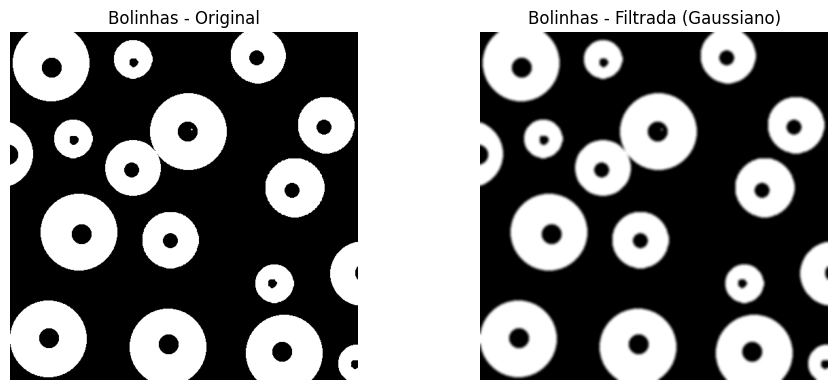

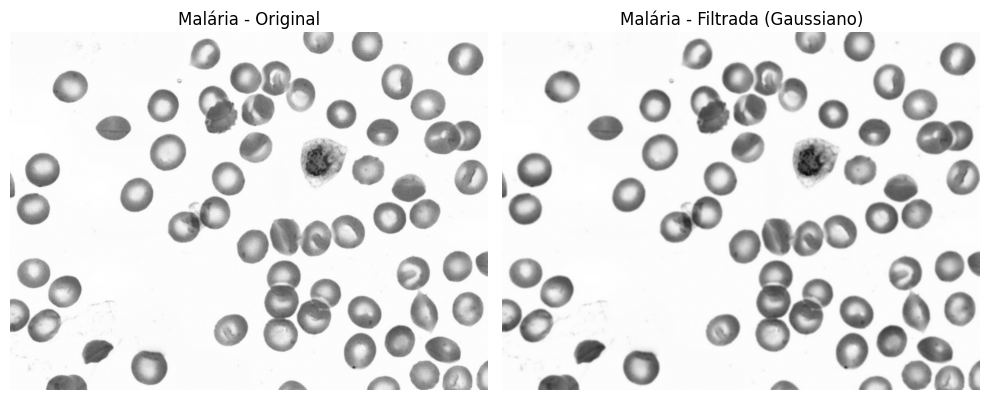

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image

# Função para ler imagem em escala de cinza
def read_grayscale_image(path):
    img = Image.open(path).convert('L')
    return np.array(img)

# Função para aplicar filtro Gaussiano
def gaussian_kernel(size=5, sigma=1):
    ax = np.linspace(-(size // 2), size // 2, size)
    kernel = np.exp(-0.5 * (ax[:, None]**2 + ax[None, :]**2) / sigma**2)
    kernel /= np.sum(kernel)
    return kernel

def convolve(image, kernel):
    pad = kernel.shape[0] // 2
    padded = np.pad(image, pad, mode='edge')
    output = np.zeros_like(image)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            region = padded[i:i+kernel.shape[0], j:j+kernel.shape[1]]
            output[i, j] = np.sum(region * kernel)
    return output

# Carregar imagem
img1 = read_grayscale_image('bolinhas.tif')
img2 = read_grayscale_image('malaria.png')

# Filtro Gaussiano leve
kernel = gaussian_kernel(size=5, sigma=1)
img1_filtered = convolve(img1, kernel)
img2_filtered = convolve(img2, kernel)

# Função para exibir imagens lado a lado
def show_preprocessing_results(original, filtered, title):
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(original, cmap='gray')
    plt.title(f'{title} - Original')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(filtered, cmap='gray')
    plt.title(f'{title} - Filtrada (Gaussiano)')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Mostrar resultados
show_preprocessing_results(img1, img1_filtered, "Bolinhas")
show_preprocessing_results(img2, img2_filtered, "Malária")

##2 - Limiarização

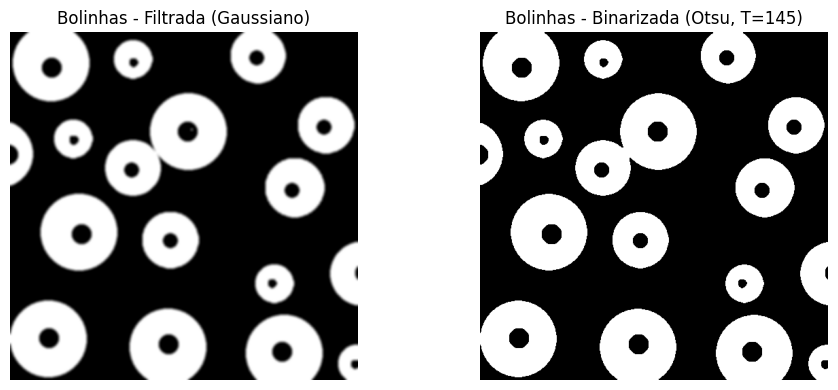

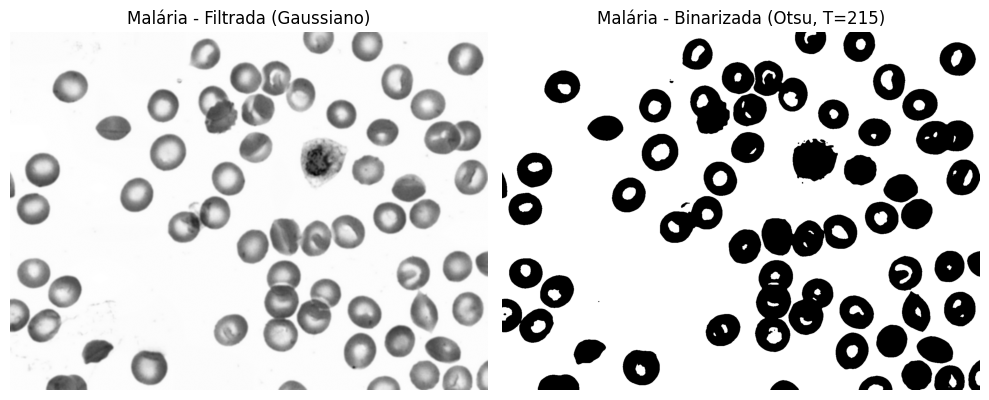

In [ ]:
def otsu_threshold(image):
    hist, bins = np.histogram(image.flatten(), 256, [0,256])
    total = image.size
    sum_total = np.dot(np.arange(256), hist)

    sumB = 0
    wB = 0
    max_var = 0
    threshold = 0

    for t in range(256):
        wB += hist[t]
        if wB == 0:
            continue
        wF = total - wB
        if wF == 0:
            break
        sumB += t * hist[t]
        mB = sumB / wB
        mF = (sum_total - sumB) / wF
        var_between = wB * wF * (mB - mF)**2
        if var_between > max_var:
            max_var = var_between
            threshold = t
    return threshold

def binarize(image, threshold):
    return (image >= threshold).astype(np.uint8)

# Aplicar Otsu e binarizar
th1 = otsu_threshold(img1_filtered)
th2 = otsu_threshold(img2_filtered)
bin1 = binarize(img1_filtered, th1)
bin2 = binarize(img2_filtered, th2)

# Função para mostrar imagem original filtrada e a binária após Otsu
def show_threshold_results(filtered, binary, title, threshold):
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(filtered, cmap='gray')
    plt.title(f'{title} - Filtrada (Gaussiano)')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(binary, cmap='gray')
    plt.title(f'{title} - Binarizada (Otsu, T={threshold})')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Mostrar resultados
show_threshold_results(img1_filtered, bin1, "Bolinhas", th1)
show_threshold_results(img2_filtered, bin2, "Malária", th2)

##3 - Operações Morfológicas

In [ ]:
def disk_kernel(radius=1):
    y,x = np.ogrid[-radius:radius+1, -radius:radius+1]
    mask = x**2 + y**2 <= radius**2
    return mask.astype(np.uint8)

def dilate(image, kernel):
    pad = kernel.shape[0] // 2
    padded = np.pad(image, pad, mode='constant')
    output = np.zeros_like(image)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            region = padded[i:i+kernel.shape[0], j:j+kernel.shape[1]]
            output[i, j] = np.max(region[kernel == 1])
    return output

def erode(image, kernel):
    pad = kernel.shape[0] // 2
    padded = np.pad(image, pad, mode='constant', constant_values=1)
    output = np.zeros_like(image)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            region = padded[i:i+kernel.shape[0], j:j+kernel.shape[1]]
            output[i, j] = np.min(region[kernel == 1])
    return output

# Fechamento
def closing(image, kernel):
    return erode(dilate(image, kernel), kernel)

# Abertura
def opening(image, kernel):
    return dilate(erode(image, kernel), kernel)

##4 - Gap-filling

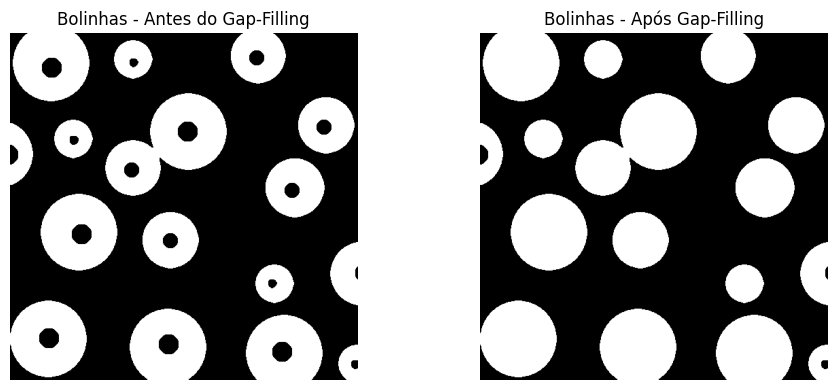

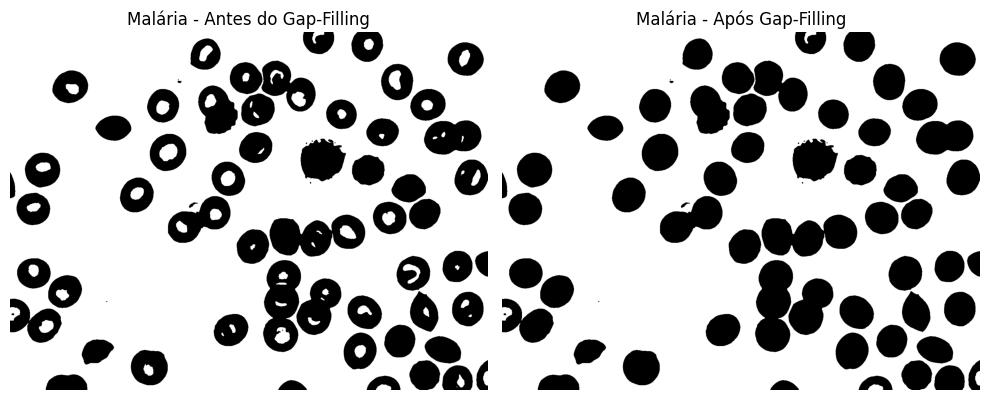

In [ ]:
def fill_holes(binary):
    filled = binary.copy()
    h, w = binary.shape
    mask = np.zeros((h+2, w+2), dtype=np.uint8)

    def flood_fill(x, y):
        stack = [(x, y)]
        while stack:
            i, j = stack.pop()
            if 0 <= i < h and 0 <= j < w and filled[i, j] == 0:
                filled[i, j] = 2
                stack += [(i+1,j), (i-1,j), (i,j+1), (i,j-1)]

    for i in range(h):
        for j in [0, w-1]:
            if filled[i, j] == 0:
                flood_fill(i, j)
    for j in range(w):
        for i in [0, h-1]:
            if filled[i, j] == 0:
                flood_fill(i, j)

    return (filled != 2).astype(np.uint8)

def fill_holes_on_black_objects(binary):
    inverted = 1 - binary
    filled = fill_holes(inverted)
    return 1 - filled

bin2_filled_fixed = fill_holes_on_black_objects(bin2)

bin1_filled = fill_holes(bin1)
bin2_filled = fill_holes(bin2)

# Função de visualização
def show_hole_filling(original_binary, filled_binary, title):
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(original_binary, cmap='gray')
    plt.title(f'{title} - Antes do Gap-Filling')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(filled_binary, cmap='gray')
    plt.title(f'{title} - Após Gap-Filling')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Mostrar resultados
show_hole_filling(bin1, bin1_filled, "Bolinhas")
show_hole_filling(bin2, bin2_filled_fixed, "Malária")

##5 - Contagem de Objetos

In [ ]:
def label_components(binary_img):
    labeled = np.zeros_like(binary_img, dtype=np.int32)
    label = 1
    h, w = binary_img.shape

    neighbors = [(-1, 0), (1, 0), (0, -1), (0, 1),
                 (-1, -1), (-1, 1), (1, -1), (1, 1)]

    def dfs(x, y):
        stack = [(x, y)]
        while stack:
            i, j = stack.pop()
            if 0 <= i < h and 0 <= j < w and binary_img[i, j] == 255 and labeled[i, j] == 0:
                labeled[i, j] = label
                for dx, dy in neighbors:
                    stack.append((i + dx, j + dy))

    for i in range(h):
        for j in range(w):
            if binary_img[i, j] == 255 and labeled[i, j] == 0:
                dfs(i, j)
                label += 1

    return labeled, label - 1

# Aplicar preenchimento correto
bin2_filled_fixed = fill_holes_on_black_objects(bin2)
bin1_filled = fill_holes(bin1)
bin2_filled = fill_holes(bin2)

# CONVERSÃO PARA 255 ANTES DE ROTULAGEM
binary_img1 = bin1 * 255
binary_img2 = bin2 * 255
filled_img1 = bin1_filled * 255
filled_img2 = bin2_filled_fixed * 255

# Rotulagem
labeled_after1, count_after1 = label_components(filled_img1)
labeled_after2, count_after2 = label_components(filled_img2)

print("Imagem 1 - Antes:", count_before1)
print("Imagem 1 - Depois:", count_after1)

print("Imagem 2 - Antes:", count_before2)
print("Imagem 2 - Depois:", count_after2)

Imagem 1 - Antes: 16
Imagem 1 - Depois: 16
Imagem 2 - Antes: 61
Imagem 2 - Depois: 5


##6 - Visualização Final com Rótulos Coloridos

### Imagem 1 - Original

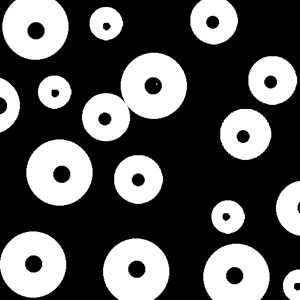

### Imagem 1 - Após Limiarização

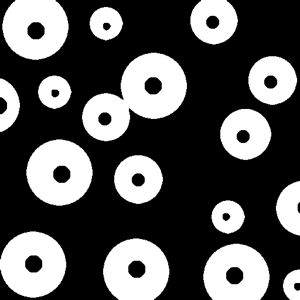

### Imagem 1 - Após Morfologia

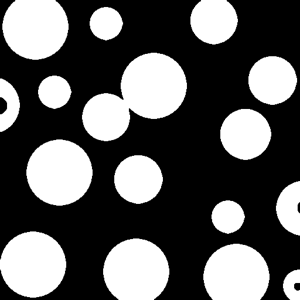

### Imagem 1 - Rótulos Coloridos (16 objetos)

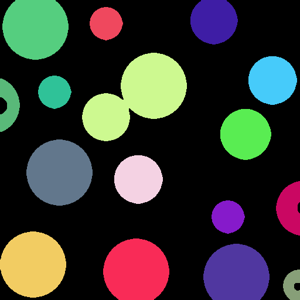

### Imagem 2 - Original

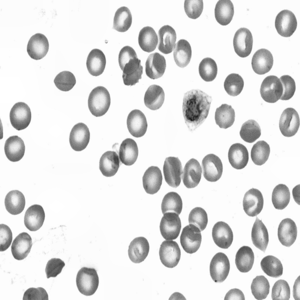

### Imagem 2 - Após Limiarização

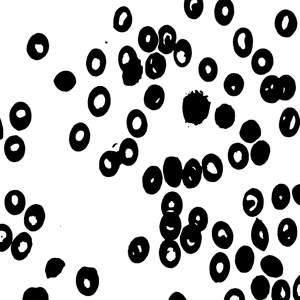

### Imagem 2 - Após Morfologia

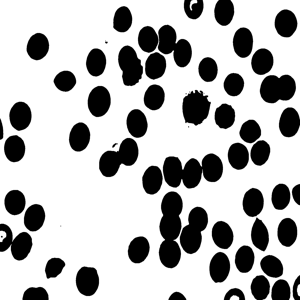

### Imagem 2 - Rótulos Coloridos (5 objetos)

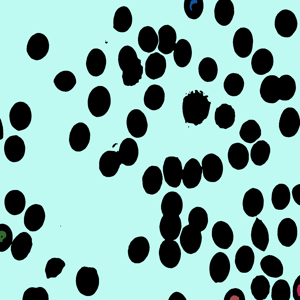

In [ ]:
from IPython.display import display, Markdown
from PIL import Image

def label_to_color(label_img):
    max_label = label_img.max()
    colors = np.random.randint(0, 255, (max_label + 1, 3), dtype=np.uint8)
    h, w = label_img.shape
    color_img = np.zeros((h, w, 3), dtype=np.uint8)
    for i in range(h):
        for j in range(w):
            if label_img[i, j] > 0:
                color_img[i, j] = colors[label_img[i, j]]
    return color_img

def show_image_with_title(img, title, size=(300, 300)):
    display(Markdown(f"### {title}"))
    if img.ndim == 2:
        pil_img = Image.fromarray(img)
    else:
        pil_img = Image.fromarray(img)
    pil_img_resized = pil_img.resize(size)
    display(pil_img_resized)

final_img1 = bin1_filled
final_img2 = bin2_filled_fixed

# Imagem 1
show_image_with_title(img1, "Imagem 1 - Original")
show_image_with_title(binary_img1, "Imagem 1 - Após Limiarização")
show_image_with_title(final_img1 * 255, "Imagem 1 - Após Morfologia")
show_image_with_title(label_to_color(labeled_after1), f"Imagem 1 - Rótulos Coloridos ({count_after1} objetos)")

# Imagem 2
show_image_with_title(img2, "Imagem 2 - Original")
show_image_with_title(binary_img2, "Imagem 2 - Após Limiarização")
show_image_with_title(final_img2 * 255, "Imagem 2 - Após Morfologia")
show_image_with_title(label_to_color(labeled_after2), f"Imagem 2 - Rótulos Coloridos ({count_after2} objetos)")
